Data: https://www.kaggle.com/competitions/vk-made-sports-image-classification/data

Inherited from https://medium.com/@abhi1thakur/fine-tuning-for-image-classification-using-pytorch-81e77d125646

In [1]:
import torch
import torch.nn as nn
from torchvision import models


NUM_CLASSES = 30


model_ft = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

model_ft.fc = nn.Sequential(
    nn.BatchNorm1d(2048),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=2048, out_features=2048),
    nn.ReLU(),
    nn.BatchNorm1d(2048),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=NUM_CLASSES),
)

device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
model_ft = model_ft.to(device)

In [2]:
from torchvision import transforms

from sport_dataset import SportDatasetTrain


IMAGE_SIZE = 224
BATCH_SIZE = 16
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]


train_dataset = SportDatasetTrain(
    transform=transforms.Compose([
        # augmentations
        transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(0.1),
        transforms.RandomRotation(10),
        
        transforms.ToTensor(),
        transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
    ])
)
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   num_workers=4)

In [3]:
import torch.optim as optim
from torch.optim import lr_scheduler

from utils import train_model


plist = [
         {'params': model_ft.layer4.parameters(), 'lr': 3e-4},
         {'params': model_ft.fc.parameters(), 'lr': 5e-3}
        ]
optimizer_ft = optim.Adam(plist, lr=0.001)
lr_sch = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)
criterion = nn.BCEWithLogitsLoss()

model_ft = train_model(model_ft,
                       train_dataset_loader,
                       len(train_dataset),
                       optimizer_ft,
                       lr_sch,
                       criterion,
                       num_epochs=4,
                       device=device)

torch.save(model_ft.state_dict(), "model.bin")

/home/maxima1ist/MADE/dl_cv/cv/sport-cv-classification/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0/3
----------


100%|██████████| 2836/2836 [15:00<00:00,  3.15it/s]


Loss: 0.0962
Epoch 1/3
----------


100%|██████████| 2836/2836 [15:12<00:00,  3.11it/s]


Loss: 0.0411
Epoch 2/3
----------


100%|██████████| 2836/2836 [15:17<00:00,  3.09it/s]


Loss: 0.0362
Epoch 3/3
----------


100%|██████████| 2836/2836 [15:13<00:00,  3.10it/s]


Loss: 0.0328


In [4]:
import numpy as np

from sport_dataset import SportDatasetTest


TEST_BATCH_SIZE = 4


test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])

test_dataset = SportDatasetTest(transform=test_transform)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=4)

model_ft.load_state_dict(torch.load("model.bin"))
model_ft = model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = False

model_ft.eval()
test_preds = np.zeros((len(test_dataset), NUM_CLASSES))
for i, x_batch in enumerate(test_dataset_loader):
    pred = model_ft(x_batch.to(device))
    test_preds[i * TEST_BATCH_SIZE:(i + 1) * TEST_BATCH_SIZE, :] = pred.detach().cpu().squeeze().numpy()

test_preds = torch.from_numpy(test_preds).float().to(device).sigmoid()
test_preds = test_preds.detach().cpu().squeeze().numpy()

In [5]:
test_dataset_for_show = SportDatasetTest()
with open("data/pred.csv", "w") as fout:
    fout.write("image_id,label\n")
    
with open("data/pred.csv", "a") as fout:
    for i, pred in enumerate(test_preds):
        path = test_dataset.get_path_by_id(i)
        file_name = path.split("/")[-1]
        image = test_dataset_for_show[i]
        label = train_dataset.idx_to_str(pred.argmax())
        fout.write(f"{file_name},{label}\n")

In [6]:
result = []

for i, pred in enumerate(test_preds):
    path = test_dataset.get_path_by_id(i)
    image = test_dataset_for_show[i]
    label = train_dataset.idx_to_str(pred.argmax())
    result.append((path, image, label))
    if len(result) > 300:
        break

In [15]:
i = 123

In [16]:
result[i][0]

'data/test/7bf6191b-54a8-4189-a914-7bbf8c33a4b8.jpeg'

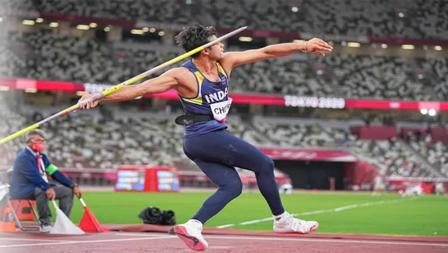

In [17]:
result[i][1]

In [18]:
result[i][2]

'javelin-throwing'